
##Setup

You will need to make a copy of this Colab notebook in your Google Drive before you can edit the homework files. You can do so with **File &rarr; Save a copy in Drive**.


In [1]:
import os
from google_drive_downloader import GoogleDriveDownloader as gdd

# Need to download the Omniglot dataset -- DON'T MODIFY THIS CELL
if not os.path.isdir('./omniglot_resized'):
    gdd.download_file_from_google_drive(file_id='1iaSFXIYC3AB8q9K_M-oVMa4pmB7yKMtI',
                                        dest_path='./omniglot_resized.zip',
                                        unzip=True)
    
assert os.path.isdir('./omniglot_resized')

Unzipping...Done.


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# config = {}
# data_folder = config.get('data_folder', './omniglot_resized')
# character_folders = [os.path.join(data_folder, family, character)
#                     for family in os.listdir(data_folder)
#                     if os.path.isdir(os.path.join(data_folder, family))
#                     for character in os.listdir(os.path.join(data_folder, family))
#                     if os.path.isdir(os.path.join(data_folder, family, character))]

# character_folders

In [2]:
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow.keras import layers
from scipy import misc
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:

def get_images(paths, labels, nb_samples=None, shuffle=True):
    """
    Takes a set of character folders and labels and returns paths to image files
    paired with labels.
    Args:
        paths: A list of character folders
        labels: List or numpy array of same length as paths
        nb_samples: Number of images to retrieve per character
    Returns:
        List of (label, image_path) tuples
    """
    if nb_samples is not None:
        sampler = lambda x: random.sample(x, nb_samples)
    else:
        sampler = lambda x: x
    images_labels = [(i, os.path.join(path, image))
                     for i, path in zip(labels, paths)
                     for image in sampler(os.listdir(path))]
    if shuffle:
        random.shuffle(images_labels)
    return images_labels


def image_file_to_array(filename, dim_input):
    """
    Takes an image path and returns numpy array
    Args:
        filename: Image filename
        dim_input: Flattened shape of image
    Returns:
        1 channel image
    """
    
    image = imageio.imread(filename)  # misc.imread(filename)
    image = image.reshape([dim_input])  # image reshape
    image = image.astype(np.float32) / 255.0  # rescale to range [0,1]
    image = 1.0 - image  # filp black and white
    return image


class DataGenerator(object):
    """
    Data Generator capable of generating batches of Omniglot data.
    A "class" is considered a class of omniglot digits.
    """

    def __init__(self, num_classes, num_samples_per_class, config={}):
        """
        Args:
            num_classes: Number of classes for classification (K-way)
            num_samples_per_class: num samples to generate per class in one batch
            batch_size: size of meta batch size (e.g. number of functions)
        """
        self.num_samples_per_class = num_samples_per_class
        self.num_classes = num_classes

        data_folder = config.get('data_folder', './omniglot_resized')
        self.img_size = config.get('img_size', (28, 28))

        self.dim_input = np.prod(self.img_size)
        self.dim_output = self.num_classes

        character_folders = [os.path.join(data_folder, family, character)
                             for family in os.listdir(data_folder)
                             if os.path.isdir(os.path.join(data_folder, family))
                             for character in os.listdir(os.path.join(data_folder, family))
                             if os.path.isdir(os.path.join(data_folder, family, character))]

        random.seed(1)
        random.shuffle(character_folders)
        num_val = 100
        num_train = 1100
        self.metatrain_character_folders = character_folders[: num_train]
        self.metaval_character_folders = character_folders[
            num_train:num_train + num_val]
        self.metatest_character_folders = character_folders[
            num_train + num_val:]

    def sample_batch(self, batch_type, batch_size):
        """
        Samples a batch for training, validation, or testing
        Args:
            batch_type: train/val/test
        Returns:
            A a tuple of (1) Image batch and (2) Label batch where
            image batch has shape [B, K, N, 784] and label batch has shape [B, K, N, N]
            where B is batch size, K is number of samples per class, N is number of classes
        """
        if batch_type == "train":
            folders = self.metatrain_character_folders
        elif batch_type == "val":
            folders = self.metaval_character_folders
        else:
            folders = self.metatest_character_folders

        #############################
        #### YOUR CODE GOES HERE ####
        N = self.num_classes
        K = self.num_samples_per_class
        all_image_batches = np.zeros((batch_size, K, N, self.dim_input))  # (B, K, N, 784)
        all_label_batches = np.zeros((batch_size, K, N, self.dim_output))  # (B, K, N, N)
        for b in range(batch_size):
            n_folders = random.sample(folders, self.num_classes)  # sample N classes
            labels = range(self.num_classes)  #
            images_labels = get_images(n_folders, labels, nb_samples=K, shuffle=True)  # (N * K)
            indices, images_path = zip(* images_labels)

            images = [image_file_to_array(image_path, self.dim_input) for image_path in images_path]
            images = np.stack(images).reshape(N, K, self.dim_input)  # (N, K, 784)
            images = np.transpose(images, [1, 0, 2])  # (K, N, 784)
            indices = np.array(indices).reshape(N, K)
            one_hot_labels = tf.one_hot(indices, depth=self.num_classes)  # (N, K, N)
            one_hot_labels = tf.transpose(one_hot_labels, perm=[1, 0, 2])  # (K, N, N)
            all_image_batches[b, ...] = images
            all_label_batches[b, ...] = one_hot_labels.numpy()
        #############################

        return all_image_batches.astype(np.float32), all_label_batches.astype(np.float32)


In [4]:

class MANN(tf.keras.Model):

    def __init__(self, num_classes, samples_per_class, num_units=128, rnn_type='lstm'):
        super(MANN, self).__init__()
        self.num_classes = num_classes
        self.samples_per_class = samples_per_class
        # self.conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='vaild')
        # self.bn1 = tf.keras.layers.BatchNormalization()
        # self.conv2 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='valid')
        # self.bn2 = tf.keras.layers.BatchNormalization()
        if rnn_type == 'lstm':
            self.layer1 = tf.keras.layers.LSTM(num_units, return_sequences=True)
            self.layer2 = tf.keras.layers.LSTM(num_classes, return_sequences=True)
        elif rnn_type == 'gru':
            self.layer1 = tf.keras.layers.GRU(num_units, return_sequences=True)
            self.layer2 = tf.keras.layers.GRU(num_classes, return_sequences=True)
        

    def call(self, input_images, input_labels):
        """
        MANN
        Args:
            input_images: [B, K+1, N, 784] flattened images
            labels: [B, K+1, N, N] ground truth labels
        Returns:
            [B, K+1, N, N] predictions
        """
        #############################
        #### YOUR CODE GOES HERE ####
        input = tf.concat([input_images, input_labels], axis=-1)  # (B, K+1, N, N+784)  [each element is of size 784+N]
        B, K, N, feature_dim = input.shape
        mask = np.ones(input.shape)
        mask[:, -1, :, self.num_classes:] = 0
        mask = tf.convert_to_tensor(mask, dtype=input.dtype)
        # input[:, self.samples_per_class + 1, :, self.num_classes:] = 0  # zero test (concatenated) label
        input = input * mask
        input = tf.reshape(input, [B, N * K, feature_dim])  # (B, (K+1) * N, 128)
        # print(f'input shape = {input.shape}')
        lstm_out = self.layer1(input)  # (B, (K+1 * N), 128)
        # print(f'lstm_out shape = {lstm_out.shape}')
        out = self.layer2(lstm_out)  # (B, (K+1) * N, N)
        # print(f'out shape = {out.shape}')
        out = tf.reshape(out, [B, K, N, N])  # (B, (K+1) * N, N)
        # print(f'out shape = {out.shape}')
        #############################
        return out

    # def loss_function(self, preds, labels):
    #     """
    #     Computes MANN loss
    #     Args:
    #         preds: [B, K+1, N, N] network output
    #         labels: [B, K+1, N, N] labels
    #     Returns:
    #         scalar loss
    #     """
    #     #############################
    #     #### YOUR CODE GOES HERE ####
    #     loss = self.loss_fn(labels[:, -1, :, :], preds[:, -1, :, :])  # one-hot representation   reduction=tf.keras.losses.Reduction.SUM
    #     return loss
        #############################


# @tf.function
# def train_step(images, labels, model, optim, eval=False):
#     with tf.GradientTape() as tape:
#         predictions = model(images, labels)
#         loss = model.loss_function(predictions, labels)
#     if not eval:
#         gradients = tape.gradient(loss, model.trainable_variables)
#         optim.apply_gradients(zip(gradients, model.trainable_variables))
#     return predictions, loss


# def run_trial(num_classes=5, num_samples=1, meta_batch_size=16, random_seed=1234):
#     random.seed(random_seed)
#     np.random.seed(random_seed)
#     tf.random.set_seed(random_seed)

#     data_generator = DataGenerator(num_classes, num_samples + 1)

#     o = MANN(num_classes, num_samples + 1)
#     optim = tf.keras.optimizers.Adam(learning_rate=0.001)
#     acc_lst = []
#     for step in range(5000):  # 25000
#         i, l = data_generator.sample_batch('train', meta_batch_size)
#         _, ls = train_step(i, l, o, optim)

#         if (step + 1) % 100 == 0:
#             print("*" * 5 + "Iter " + str(step + 1) + "*" * 5)
#             i, l = data_generator.sample_batch('test', 100)
#             pred, tls = train_step(i, l, o, optim, eval=True)
#             print("Train Loss:", ls.numpy(), "Test Loss:", tls.numpy())
#             pred = tf.reshape(pred, [-1, num_samples + 1, num_classes, num_classes])
#             pred = tf.math.argmax(pred[:, -1, :, :], axis=2)
#             l = tf.math.argmax(l[:, -1, :, :], axis=2)
#             test_acc = tf.reduce_mean(tf.cast(tf.math.equal(pred, l), tf.float32)).numpy()
#             print("Test Accuracy", test_acc)
#             acc_lst.append(test_acc)
#     return acc_lst


In [11]:
class Trainer:
    def __init__(self, model, num_classes, num_samples, optim, data_generator, random_seed=1234):
        self.model = model
        self.num_classes = num_classes
        self.num_samples = num_samples
        self.optim = optim
        self.loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        self.data_generator = data_generator
        self.seed =  random_seed
        

    def loss_function(self, preds, labels):
        """
        Computes MANN loss
        Args:
            preds: [B, K+1, N, N] network output
            labels: [B, K+1, N, N] labels
        Returns:
            scalar loss
        """
        # reduction=tf.keras.losses.Reduction.SUM
        loss = self.loss_fn(labels[:, -1, :, :], preds[:, -1, :, :])  # one-hot representation  
        return loss
    
    @tf.function
    def train_step(self, images, labels, eval=False):
        with tf.GradientTape() as tape:
            predictions = self.model(images, labels)
            loss = self.loss_function(predictions, labels)
        if not eval:
            gradients = tape.gradient(loss, self.model.trainable_variables)
            optim.apply_gradients(zip(gradients, self.model.trainable_variables))
        return predictions, loss


    def train_model(self, batch_size=16):
        random.seed(self.seed)
        np.random.seed(self.seed)
        tf.random.set_seed(self.seed)

        acc_lst = []
        for step in range(3000):  # 25000
            imgs, labels = self.data_generator.sample_batch('train', batch_size)
            _, trn_loss = self.train_step(imgs, labels)

            if (step + 1) % 100 == 0:
                print("*" * 5 + "Iter " + str(step + 1) + "*" * 5)
                imgs, labels_oh = data_generator.sample_batch('test', 100)
                preds, test_loss = self.train_step(imgs, labels_oh, eval=True)
                print("Train Loss:", trn_loss.numpy(), "Test Loss:", test_loss.numpy())
                preds = tf.reshape(preds, [-1, self.num_samples + 1, self.num_classes, self.num_classes])
                preds = tf.math.argmax(preds[:, -1, :, :], axis=2)
                labels = tf.math.argmax(labels_oh[:, -1, :, :], axis=2)
                test_acc = tf.reduce_mean(tf.cast(tf.math.equal(preds, labels), tf.float32)).numpy()
                print("Test Accuracy", test_acc)
                acc_lst.append(test_acc)
        return acc_lst


In [9]:
# results = main(num_classes=5, num_samples=1, meta_batch_size=16, random_seed=1234)
#############################
#### YOUR CODE GOES HERE ####

configs = {'num_classes': [2, 3, 4, 4], 'num_samples': [1, 1, 1, 5]}
test_acc_lst = []
num_classes_lst = configs['num_classes']
num_samples_lst = configs['num_samples']
LR = 0.001
META_BATCH_SIZE = 16
optim = tf.keras.optimizers.Adam(learning_rate=LR)

for i, num_classes in enumerate(num_classes_lst):
    num_samples = num_samples_lst[i]
    print(f'trial i:\tnum_examples = {num_classes}\tnum_samples = {num_samples}')
    data_generator = DataGenerator(num_classes, num_samples + 1)
    model = MANN(num_classes, num_samples + 1)
    trainer = Trainer(model, num_classes, num_samples, optim, data_generator)
    trial_test_acc = trainer.train_model(META_BATCH_SIZE)
    test_acc_lst.append(trial_test_acc)
#############################

trial i:	num_examples = 2	num_samples = 1
*****Iter 100*****
Train Loss: 0.62796855 Test Loss: 0.60045177
Test Accuracy 0.65


KeyboardInterrupt: ignored

In [ ]:
def acc_plot(acc_lst, num_classes, num_smaples):
    plt.plot(acc_lst)
    plt.title(f'Test Accuracy with {num_classes} classes and {num_samples} samples')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.show()

In [ ]:
test_acc_lst

[[0.65,
  0.675,
  0.665,
  0.66,
  0.65,
  0.665,
  0.675,
  0.67,
  0.685,
  0.66,
  0.635,
  0.685,
  0.675,
  0.64,
  0.68,
  0.66,
  0.67,
  0.67,
  0.625,
  0.66,
  0.68,
  0.675,
  0.69,
  0.705,
  0.64,
  0.625,
  0.65,
  0.65,
  0.64,
  0.695,
  0.645,
  0.66,
  0.69,
  0.725,
  0.66,
  0.67,
  0.67,
  0.7,
  0.675,
  0.665,
  0.655,
  0.685,
  0.72,
  0.69,
  0.665,
  0.65,
  0.655,
  0.64,
  0.665,
  0.67],
 [0.39333335,
  0.48,
  0.51,
  0.52,
  0.5133333,
  0.53333336,
  0.5366667,
  0.5466667,
  0.53333336,
  0.5566667,
  0.49,
  0.5366667,
  0.50666666,
  0.52666664,
  0.5466667,
  0.49666667,
  0.50333333,
  0.5233333,
  0.53333336,
  0.55,
  0.55333334,
  0.5,
  0.49333334,
  0.54333335,
  0.53333336,
  0.53333336,
  0.56333333,
  0.5233333,
  0.56333333,
  0.55,
  0.54,
  0.56,
  0.53,
  0.56666666,
  0.52666664,
  0.5133333,
  0.51,
  0.5,
  0.56666666,
  0.51,
  0.54333335,
  0.5233333,
  0.5566667,
  0.5133333,
  0.50666666,
  0.53,
  0.5566667,
  0.56333333,
  0.5

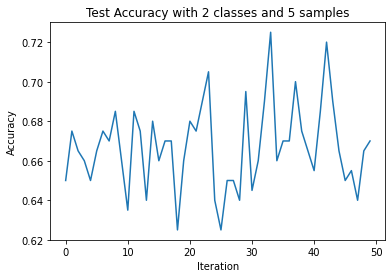

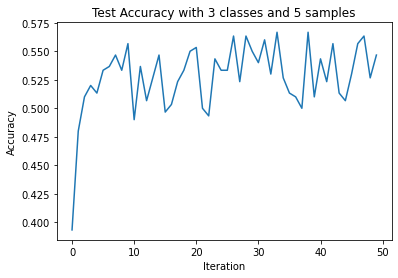

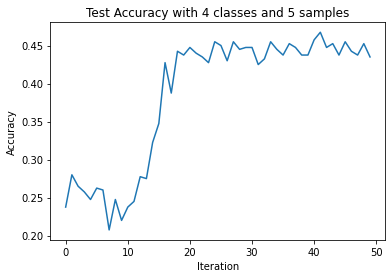

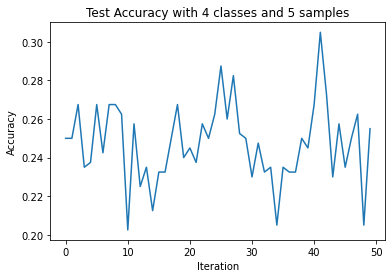

In [ ]:
for i in range(len(test_acc_lst)):
    acc_plot(test_acc_lst[i], num_classes_lst[i], num_samples_lst[i])

## 1-Shot 3-Way analysis
### way- number of classes
### shot- examples per class

In [12]:

# check batch_size (16, 32, 64?), lr (1e-3, 1e-4, 1e-2), GRU

# configs = {'num_classes': [2, 3, 4, 4], 'num_samples': [1, 1, 1, 5]}
NUM_CLASSES = 3  # WAY
NUM_SAMPLES = 1  # SHOT

RNN_TYPE = ['lstm', 'gru']  # or 'gru'
LRS = [1e-4, 1e-3, 1e-2]
BATCH_SIZES = [16, 32, 64]
test_acc_lst = []

best_acc = 0
for rnn_type in RNN_TYPE:
    for lr in LRS:
        optim = tf.keras.optimizers.Adam(learning_rate=lr)
        for batch_size in BATCH_SIZES:
            print(f'trial:\nMANN ({rnn_type}) with batch={batch_size} and lr={lr}')
            data_generator = DataGenerator(NUM_CLASSES, NUM_SAMPLES + 1)
            model = MANN(NUM_CLASSES, NUM_SAMPLES + 1)
            trainer = Trainer(model, NUM_CLASSES, NUM_SAMPLES, optim, data_generator)
            trial_test_acc = trainer.train_model(batch_size)
            tmp_best_acc = np.max(trial_test_acc)
            if tmp_best_acc > best_acc:
                print(f'best trial (so far):\nMANN ({rnn_type}) with batch={batch_size} and lr={lr}')
                print(f'best accuracy = {best_acc}')
                best_acc = tmp_best_acc
            # data_generator = DataGenerator(num_classes, num_samples + 1)
            # model = MANN(num_classes, num_samples + 1)
            # trainer = Trainer(model, num_classes, num_samples, optim, data_generator)

            test_acc_lst.append(trial_test_acc)

trial:
MANN (lstm) with batch=16 and lr=0.0001
*****Iter 100*****
Train Loss: 1.0910591 Test Loss: 1.0944878
Test Accuracy 0.38
*****Iter 200*****
Train Loss: 1.0761721 Test Loss: 1.0791022
Test Accuracy 0.42
*****Iter 300*****
Train Loss: 1.04525 Test Loss: 1.0493388
Test Accuracy 0.46
*****Iter 400*****
Train Loss: 0.97611475 Test Loss: 1.0028082
Test Accuracy 0.47333333
*****Iter 500*****
Train Loss: 0.964727 Test Loss: 0.96512634
Test Accuracy 0.53
*****Iter 600*****
Train Loss: 0.99628705 Test Loss: 0.95728946
Test Accuracy 0.50333333
*****Iter 700*****
Train Loss: 0.9882342 Test Loss: 0.9213932
Test Accuracy 0.5366667
*****Iter 800*****
Train Loss: 0.91856986 Test Loss: 0.9100041
Test Accuracy 0.54333335
*****Iter 900*****
Train Loss: 0.9201467 Test Loss: 0.91818094
Test Accuracy 0.52
*****Iter 1000*****
Train Loss: 0.86357456 Test Loss: 0.88237184
Test Accuracy 0.55333334
*****Iter 1100*****
Train Loss: 0.97862047 Test Loss: 0.92055684
Test Accuracy 0.5133333
*****Iter 1200*****

In [16]:
NUM_CLASSES = 3  # WAY
NUM_SAMPLES = 1  # SHOT

RNN_TYPE = ['lstm', 'gru']  # or 'gru'
lr = 1e-3
BATCH_SIZES = [32, 64]
num_units = 256
test_acc_lst = []

best_acc = 0
for rnn_type in RNN_TYPE:
    optim = tf.keras.optimizers.Adam(learning_rate=lr)
    for batch_size in BATCH_SIZES:
        print(f'trial:\nMANN ({rnn_type}) with batch={batch_size} and lr={lr}')
        data_generator = DataGenerator(NUM_CLASSES, NUM_SAMPLES + 1)
        model = MANN(NUM_CLASSES, NUM_SAMPLES + 1, num_units=num_units,rnn_type=rnn_type)
        trainer = Trainer(model, NUM_CLASSES, NUM_SAMPLES, optim, data_generator)
        trial_test_acc = trainer.train_model(batch_size)
        tmp_best_acc = np.max(trial_test_acc)
        if tmp_best_acc > best_acc:
            print(f'best trial (so far):\nMANN ({rnn_type}) with batch={batch_size} and lr={lr}')
            best_acc = tmp_best_acc
            print(f'best accuracy = {best_acc}')
        # data_generator = DataGenerator(num_classes, num_samples + 1)
        # model = MANN(num_classes, num_samples + 1)
        # trainer = Trainer(model, num_classes, num_samples, optim, data_generator)

        test_acc_lst.append(trial_test_acc)

trial:
MANN (lstm) with batch=32 and lr=0.001
*****Iter 100*****
Train Loss: 0.960649 Test Loss: 0.9678202
Test Accuracy 0.51666665
*****Iter 200*****
Train Loss: 0.90674525 Test Loss: 0.9112021
Test Accuracy 0.52666664
*****Iter 300*****
Train Loss: 0.94398314 Test Loss: 0.9040694
Test Accuracy 0.5233333
*****Iter 400*****
Train Loss: 0.9022689 Test Loss: 0.8938098
Test Accuracy 0.5366667
*****Iter 500*****
Train Loss: 0.8731522 Test Loss: 0.8837109
Test Accuracy 0.54333335
*****Iter 600*****
Train Loss: 0.8781767 Test Loss: 0.90490395
Test Accuracy 0.51666665
*****Iter 700*****
Train Loss: 0.9097171 Test Loss: 0.8987949
Test Accuracy 0.51
*****Iter 800*****
Train Loss: 0.88448924 Test Loss: 0.8717585
Test Accuracy 0.5366667
*****Iter 900*****
Train Loss: 0.9278083 Test Loss: 0.8745108
Test Accuracy 0.54333335
*****Iter 1000*****
Train Loss: 0.8832872 Test Loss: 0.9172267
Test Accuracy 0.51
*****Iter 1100*****
Train Loss: 0.880891 Test Loss: 0.873141
Test Accuracy 0.54
*****Iter 1200*

In [ ]:
# TODO:
# IMPLEMENT SNAIL!